In [1]:
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import mpl_toolkits.axes_grid1
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from ipywidgets import interact
# from IPython.display import HTML
from skimage.measure import compare_ssim, compare_psnr
from scipy.ndimage import gaussian_filter
from utils.analysis import min_max, index2value
from utils.plot import single_plot, multiple_plot, pred_plot
from utils.tof import cal_raw_depth_form_Q, cal_intensity_form_Q, return_Q, rotate_Q, gate_calib, obs_data_loader, set_reg
from utils.scatter import phase_function
from utils.estimate import pred_drs_cpu
from utils.args import decode_LUT_args, const_LUT_args
from tqdm.notebook import tqdm

# register fileの設定

+ default: 普通の3-tap ToF用のレジスタファイル
+ ours: 提案手法のレジスタファイル
+ 注意事項: light_startは，実際には5ck遅れて立ち上がることを考慮して，5ck早めに設定しています．
+ ゲート図の見方: 上から，光源照射の設定タイミング，実際の光源照射タイミング，Q1, Q2, Q3, QDの立ち上がり立ち下がりになっています．

saved to  ./registerfiles/reg_default.txt


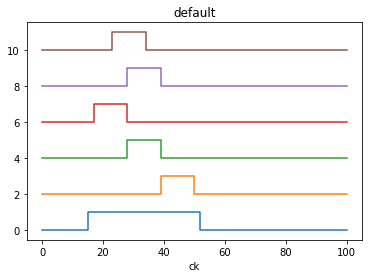

In [2]:
exp_name = "default"
G1_width = 11
G2_width = 11
G3_width = 11
light_width = 11
light_start = 23
gate_start = 17

set_reg(exp_name, reg_root='./registerfiles/',
        gate_start=gate_start, Light_start=light_start, 
        G1_width=G1_width, G2_width=G2_width, G3_width=G3_width, Light_width=light_width)

saved to  ./registerfiles/reg_ours.txt


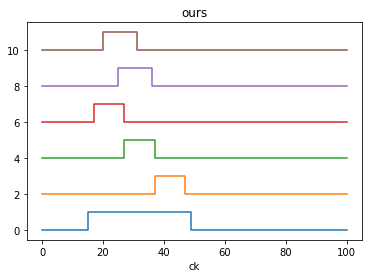

In [3]:
exp_name = 'ours'
G1_width = 10
G2_width = 10
G3_width = 10
Light_width = 11
gate_start=17
light_start=20

set_reg(exp_name, reg_root='./registerfiles/',
        gate_start=gate_start, Light_start=light_start, 
        G1_width=G1_width, G2_width=G2_width, G3_width=G3_width, Light_width=Light_width)

# LUTの作成

+ 2.5GB程度のメモリが必要
+ integration count = 60000のとき amp=0.008にしたらうまくいく (マジックパラメータ)

In [12]:
%%bash
python3 const_LUT_cpu.py --dist_size 800 --ref_size 200 --sigma_size 1000 --scene_scale 1 --temporal_size 2000 --amp 1.0 --disparity 0.03 --g 90 --rho 98 --light_clock 11 --g1_clock 2.0 --g2_clock 10.0 --g3_clock 10.0 --interval_clock 0.0 --dist_min 0.8 --dist_max 4.8 --sigma_max 0.10 --sigma_min 0.0 --result_dir './LUT/'


- Setup is completed. : 0.02258467674255371 [s]
Start saving
Save is completed 3.3189046382904053
- Saved to: ./LUT/


100%|██████████| 800/800 [00:08<00:00, 91.54it/s]


In [21]:
LUT_args = decode_LUT_args('./LUT')
Q1_LUT = np.load('./LUT/Q1.npy') * 0.008
Q2_LUT = np.load('./LUT/Q2.npy') * 0.008
Q3_LUT = np.load('./LUT/Q3.npy') * 0.008

# 観測データの読み込み

+ Q_input: (row, col, Q1-3, fog/clear, ours/default) = (120, 160, 3, 2, 2)

In [23]:
row = 120
col = 160
exp_type=['clear', 'fog']
reg_type=['ours', 'default']
reg_amb_type=['ours_amb', 'default_amb']
Q_input = obs_data_loader(exp_data_root='./data',
                    exp_type=exp_type,
                    reg_type=reg_type,
                    reg_amb_type=reg_amb_type, 
                    rot=1,
                    x_start=40, x_range=160, y_start=208, y_range=120, ch=3)



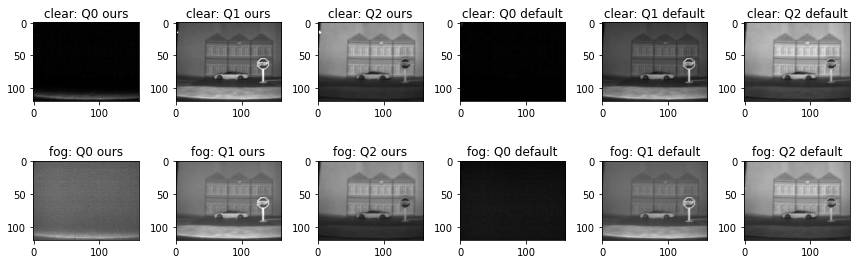

In [24]:
fig = plt.figure(figsize=(12,4))
ax = fig.subplots(2, 6)
for e in range(2):
    for i in range(3):
        if i ==0:
            vmax=50
        else:
            vmax=1000
            
        ax[e, i].imshow(Q_input[:, :, i, e, 0], vmax=vmax, vmin=0, cmap='gray')
        ax[e, i].set_title(exp_type[e] + ': Q'+ str(i) + ' ' + reg_type[0])
        ax[e, i+3].imshow(Q_input[:, :, i, e, 1], vmax=vmax, vmin=0, cmap='gray')
        ax[e, i+3].set_title(exp_type[e] + ': Q'+ str(i) + ' ' + reg_type[1])
plt.tight_layout()
plt.show()

# 観測データの処理

+ 通常の3tap ToF

In [25]:
depth_ordinary = np.zeros([row, col, len(exp_type)])
intensity_ordinary = np.zeros([row, col, len(exp_type)])
for e in range(len(exp_type)):
    depth_ordinary[:, :, e] = cal_raw_depth_form_Q(Q_input[:, :, :, e, 1], light_clock=11, clock_ns=2.65, c=3e8)
    intensity_ordinary[:, :, e] = cal_intensity_form_Q(Q_input[:, :, :, e, 1])

+ 提案手法

In [26]:
drs_pred = np.zeros([row*col, 3, len(exp_type)])
Intensity_defogged = np.zeros([row*col, len(exp_type)])
Q_pred = np.zeros([row*col, 3, len(exp_type)])
Q_error = np.zeros([row*col, 3, len(exp_type)])

for e in tqdm(range(len(exp_type))):
    drs_pred[:, :, e], Intensity_defogged[:, e], Q_pred[:, :, e], Q_error[:, :, e]\
    = pred_drs_cpu(Q_input[:, :, :, e, 0].reshape(row*col, -1), 
                    Q1_LUT, Q2_LUT, Q3_LUT, LUT_args, nan_th=4095)


100%|██████████| 19200/19200 [02:33<00:00, 125.27it/s]

# 結果の可視化
+ 上段: 霧なし
+ 下段: 霧あり (通常ToFは輝度画像は少し不鮮明になり距離も誤る一方，提案手法は距離も正しく推定できた)

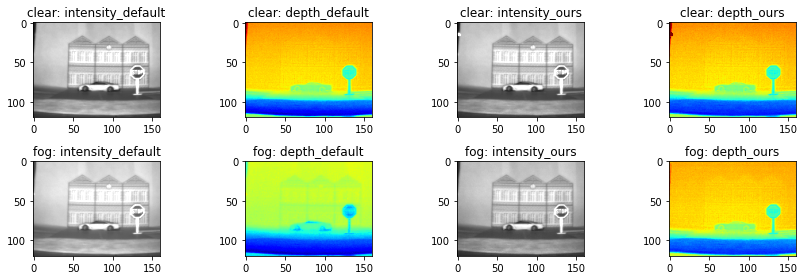

In [28]:
fig = plt.figure(figsize=(12,4))
ax = fig.subplots(2, 4)
for e in range(2):
        ax[e, 0].imshow(intensity_ordinary[:, :, e], vmax=1200, vmin=0.0, cmap='gray')
        ax[e, 0].set_title(exp_type[e] + ': intensity_'+ reg_type[1])
        
        ax[e, 1].imshow(depth_ordinary[:, :, e], vmax=4.0, vmin=0.8, cmap='jet')
        ax[e, 1].set_title(exp_type[e] + ': depth_'+ reg_type[1])
    
        ax[e, 2].imshow(Intensity_defogged[:, e].reshape(row, col, -1), vmax=1200, vmin=0.0, cmap='gray')
        ax[e, 2].set_title(exp_type[e] + ': intensity_' + reg_type[0])
        
        ax[e, 3].imshow(drs_pred[:, 0, e].reshape(row, col, -1), vmax=4.0, vmin=0.8, cmap='jet')
        ax[e, 3].set_title(exp_type[e] + ': depth_' + reg_type[0])
        
plt.tight_layout()
plt.show()